In [1]:
from IPython.display import HTML

In [2]:
HTML("""
<style>
    #notebook-container {
    width: 80% !important;
}
.dataTable {
    width: 100% !important;
}
.dataTables_scrollBody {
    width: 100% !important;
}
.dataTables_scrollHead {
    width: 100% !important;
}
.dataTables_filter {
   float: right !important;
}
.output_html {
    max-width: calc(100%) !important;
}
.rendered{
    font-size: 125%;
}
</style>
""")

In [3]:
html1 = '<img src="https://cdn.ifsc-climbing.org/images/News/Placeholders/IFSC_News_-_IFSC_placeholder.jpg" width="900" text-align="center"/>'
HTML(html1)

# IFSC World Cup Bouldering Analysis

The International Federation of Sport Climbing ([IFSC](https://www.ifsc-climbing.org/)) was founded in 2007 with the goal of encouraging, promoting, and developing the sport of climbing worldwide. With its addition to the most recent [Summer Olympics](https://olympics.com/en/sports/sport-climbing/), climbing in general has seen a huge spike in interest. Speed climbing in particular has taken the title of "Fastest Sport" in the Olympic games, with the fastest time of just barely over 5 seconds! (Update: As of the most recent event - Seoul 2023 - [Leonardo Veddriq](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=3340) set the world's *fastest* time ever by breaking the sub-5 second climb! He did it not once, but *[three times](https://olympics.com/en/news/ifsc-climbing-world-cup-2023-seoul-speed-record)*!) But this project isn't going to focus on speed - rather, it's going  to focus on the wonderful discipline of [bouldering](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiy0vaGl87-AhVmJEQIHVoTCTQQFnoECE4QAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FBouldering&usg=AOvVaw2NEyaJhSIoQOZarHveFkWy).

Bouldering is rock climbing in its purest form. No ropes, no harnesses - just you and the wall. With bouldering being one of the more accessible disciplines in climbing (the others being [lead](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiu76PzlM7-AhWgJ0QIHaerAMsQFnoECBkQAw&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FLead_climbing&usg=AOvVaw35RDg9EAD7fL1lNoQQOkPk) and [speed](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi80Yr8lM7-AhWUKEQIHbijAP0QFnoECBUQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FSpeed_climbing&usg=AOvVaw2tZ7FhGxzCcb18zN0so1dU)), it's no surprise that it's rapidly growing in popularity worldwide. All you need is a pair of climbing shoes, some chalk, and a willingness to push yourself to your absolute limits. 

## Project Goals

In this analysis, I aim to help shed some light on boulderers from around the world. I have scraped the results from the IFSC website for all of the World Cup Events from 2007 to present day in the hopes of answering the following questions:
* Who are the most successful climbers?
    * Who has the most gold medals?
    * Which climbers have made it to the finals the most?
* Which country produces the best climbers?
    * Are any countries more dominant than others?
* How have climbers performed over time?
    * Do any climbers stand out from the rest?
    
I aim to update this every time a new event takes place, so that the results and the analysis are as up-to-date as possible.

In [4]:
# IMPORT LIBRARIES & TOOLS
import pandas as pd
import numpy as np
import itables
import glob
import os
import re
import plot

import seaborn as sns
# import cufflinks as cf
# import chart_studio.plotly as py
# import plotly.express as px
# import plotly.graph_objects as go
# import matplotlib.pyplot as plt

# from plotly.offline import download_plotlyjs, init_notebook_mode
# init_notebook_mode(connected=True)
itables.init_notebook_mode(all_interactive=False)
# cf.go_offline()

# # Remove unnecessary control items in figures (for Plotly)
# config = {
#     'modeBarButtonsToRemove': ['zoomIn', 'zoomOut', 'resetScale2d', 'select2d', 'lasso2d'],
#     'responsive': True,
#     'displaylogo': False,
#     'toImageButtonOptions': {
#         'format': 'png',  # one of png, svg, jpeg, webp
#         'filename': 'ifsc-analysis',
#         'scale': 1
#       }
# }

#SET UP DIRECTORY STRUCTURE
DATA_DIR = os.path.join(
    os.path.dirname(os.path.realpath("__file__")), "data"
)

BOULDER_DIR       = os.path.join(DATA_DIR, "Boulder")
BOULDER_MEN_DIR   = os.path.join(DATA_DIR, "Boulder/Men")
BOULDER_WOMEN_DIR = os.path.join(DATA_DIR, "Boulder/Women")

# HELPER FUNCTIONS
def convert_score(score):
    """
    Returns a new string representing the converted score.
    Old syntax: xTw yBz
    New syntax: xTyZ w x
    x,y,w,z: number of attempts
    T, B/Z: tops & zones, respectively
    
    score: string representation of climber's results
    """
    if score:
        tmp = str(score)
        if 'b' in tmp.lower():
            tops, top_att = tmp.lower().split()[0].split('t')
            zones, zone_att = tmp.lower().split()[1].split('b')
            new_score = tops + 'T' + zones + 'Z ' + top_att + ' ' + zone_att
            return new_score
        return score
    return score

def check_climber(df, name):
    """
    Returns a dataframe showing results for each event for given
    climber.
    
    df: dataframe containing results for all bouldering events
    name: name of climber you want to examine
    """
    name = name.upper()
    individual = df.groupby(df['Name']).get_group(name).reset_index(drop=True)
    return individual

def count_round_appearances(df, name):
    """
    Prints a count of the number of times a climber has made it
    to a specific round.
    
    df: df containing results from all scraped events
    name: name of climber you want to examine
    """
    name = name.upper()
    # Gets number of time climber appeared for each round
    q = df.groupby(df['Name']).get_group(name).count()['Qualification']
    s = df.groupby(df['Name']).get_group(name).count()['Semi-Final']
    f = df.groupby(df['Name']).get_group(name).count()['Final']
    
    print(f'{name} appearances:')
    print(f'{"Qualification round:" :>20} {q :>3}')
    print(f'{"Semi-Final round:" :>20} {s :>3}')
    print(f'{"Final round:" :>20} {f :>3}')
    
def get_bouldering_results():
    """
    Combines all .csv files in given directory into a single dataframe.
    
    directory: directory containing all the .csv files
    """
    # Grabs all .csv files in given directory and combine into dataframe
    all_events = glob.glob(os.path.join(BOULDER_DIR, "*/*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_events), ignore_index=True)
        
    # Clean up some column/datatype issues
    df['Year'] = df['Event'].apply(lambda x: re.search("(\d{4})", x).group(1)) # Gets year of event
    df['Year'] = df['Year'].astype(int)
    df['Event'] = df['Event'].str.replace('IFSC - C', 'IFSC C').str.replace('Worldcup', 'World Cup')
    df['Location'] = df['Event'].str.split().str[-2].str[1:4]
    df['Rank'] = df['Rank'].fillna(-1).astype('int') # Fixes DNS rank    
    df['Qualification'] = df['Qualification'].apply(convert_score) # Fixes old scoring syntax
    df['Semi-Final'] = df['Semi-Final'].apply(convert_score)
    df['Final'] = df['Final'].apply(convert_score)
    
    # Special cases
    idx = df.index[df['Event'] == 'IFSC Climbing World Cup (B) - Sheffield (GBR) 2010']
    df.loc[idx,['Semi-Final','Final']] = df.loc[idx,['Final','Semi-Final']].values # Swap columns
    df.loc[(df['Final'].notna()) & (df['Rank'] > 6), 'Final'] = np.nan # Ignore final columns for Women rank > 6
    df['Location'] = df['Location'].replace(to_replace={'osc': 'RUS'}) # renames location to correct country
        
    return df

def show_table(df, col=0, center=0, srt="desc"):
    """
    Function to display an itable for the given dataframe.
    
    df: the dataframe to be displayed
    col: the col you want to sort on
    center: flag to determine whether or not to center the table (not working)
    srt: the sorting order
    """
    if center:
        return itables.show(df, maxBytes=1e6, scrollY="400px", scrollCollapse=True, paging=False, style="margin:auto")
    else:
        return itables.show(df,
                            classes="hover order-column dt-head-right dt-body-right",
                            maxBytes=1e6,
                            scrollY="400px",
                            scrollCollapse=True,
                            lengthMenu=[20, 50, 100],
                            order=[[col, srt]])

# IMPORT SCRAPED DATA
all_results = get_bouldering_results()
boulder_men_all_results = all_results[all_results['Gender'] == 'M']
boulder_women_all_results = all_results[all_results['Gender'] == 'F']

# Constant to be used in other functions
YEARS     = np.unique(all_results['Year'])
NAMES     = np.unique(all_results['Name'])
COUNTRIES = np.unique(all_results['Country'])
LOCATIONS = np.unique(all_results['Location'])
GENDERS   = np.unique(all_results['Gender'])
ROUNDS    = ['Qualification', 'Semi-Final', 'Final']

<IPython.core.display.Javascript object>

## IFSC Competition Data

Below is a combination of *every* IFSC World Cup event result since 2007. It contains the event name, athlete id, rank, name, gender, country, year, and scores for every single competitor. We will be using this data as a base, and manipulating it to get more desirable data.

*NOTE*: I would like to note that due to the way IFSC recorded the results, unforseen circumstances like bad weather, or injury, some events were not always played through completion or recorded properly. For example, on several occasions the weather was so severe that some rounds had to be skipped altogether. The most recent of which was in Seoul 2023, where the rain caused the entire semi-finals and finals to be combined into one. This means that if you qualified for the semi-finals, you were essentially competiting in the finals as well. Another example is when a climber qualifies for the semi-finals/finals, but then becomes injured and decides not to compete. For the sake of this project, I have decided to include as many accurate results as I can - meaning that if a climber qualified for a round but did not participate, I still count it toward that climber's statistics. There may be some small discrepancies in the numbers I present compared to their actual values.

In [5]:
show_table(all_results, 9)

As we can see from the above, there are almost 14,000 rows of data across *all* of the World Cup events we scraped earlier. Each row contains that climber's scores for that specific event. A quick note on [how to interpret the scores](https://www.ifsc-climbing.org/index.php/component/k2/item/774-tops-zones-attempts-the-bouldering-score-reviewed): The number in *front* of the 'T' (Top) indicates how many Tops the climber got - the higher the number, the better. The number in *front* of the 'Z' (Zone) indicates how many Zones the climber got - similar to Tops, the higher the better. The *first* number *after* the 'Z' indicates how many *attempts* the climber took to reach the top, while the *second* number after the 'Z' indicates how many attempts the climber took to reach the zone. Tops take priority, followed by zones, then by attempts in case of a tie. An ideal score for a bouldering round with four boulders would look like '4T4Z 4 4', indicating that the climber reached the top of all four boulders in their first attempt (a.k.a. "flashing").

We can use the search bar to look at the results of just a single climber to get an idea of their overall performance. For example, one of my favorite climbers is the two-time Bouldering World Cup Gold Winner [Jongwon Chon](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=2052) from South Korea. If we type his name into the search bar above you can see all of his results from his participation in the IFSC. You can see a quick summary of his appearances below.

In [6]:
count_round_appearances(all_results, 'jongwon chon')

JONGWON CHON appearances:
Qualification round:  48
   Semi-Final round:  43
        Final round:  27


As seen above, Jongwon Chon has appeared in 48 qualification rounds (as of May 1, 2023), and has made it to an astounding 27 finals! That's incredibly impressive considering how difficult it is to consistently perform at such a high level!

# Climber Statistics

The table below contains more statistics related to each climber's performance during their IFSC career. 

In [7]:
def get_bouldering_stats(df):
    """
    Returns a dataframe showing the top 3 climbers (if applicable)
    grouped by country.
    
    df: dataframe containing aggregated results for each unique climber
    """    
    # Create a new dataframe with athlete's ID, name, and country
    clean_df = df.drop_duplicates(subset=['Name', 'ID'])[['ID', 'Name', 'Gender', 'Country']]

    # Counts number of appearances per round per climber
    qual_all = df.groupby(['ID', 'Name'])['Qualification'].count()
    semi_app = df.groupby(['ID', 'Name'])['Semi-Final'].count()
    final_app = df.groupby(['ID', 'Name'])['Final'].count()

    # Merges the above dataframes
    rounds = pd.merge(pd.merge(qual_all, semi_app , left_on=['ID', 'Name'], right_index=True), final_app, left_on=['ID', 'Name'], right_index=True)
    clean_df = pd.merge(clean_df, rounds, left_on=['ID', 'Name'], right_index=True)

    # Calculates percentages of appearances in each round
    clean_df['Q_Pct'] = round((clean_df['Qualification'] / clean_df['Qualification']) * 100, 2)
    clean_df['S_Pct'] = round((clean_df['Semi-Final'] / clean_df['Qualification']) * 100, 2)
    clean_df['F_Pct'] = round((clean_df['Final'] / clean_df['Qualification']) * 100, 2)
    clean_df = clean_df.sort_values('Final', ascending=False).reset_index(drop=True)

    # Saves data to .csv file
    file = os.path.join(DATA_DIR, "boulder_stats_all.csv")
    clean_df.to_csv(file)
    
    return clean_df

# def get_height(df, cat, stats_df):
    # Convert 'ID' to string so we can scrape site for heights (~33 minutes)
    # print(f'Gathering {cat}\'s height - please be patient...')
    # df['ID'] = df['ID'].apply(str)
    # scraper = IFSCScraper()
    # df['Height'] = df['ID'].apply(lambda x: scraper.get_athlete_height(x))
    # scraper.end_session()

    # Number of climbers that have a height listed on the IFSC site
    # have_height = (~stats_df['Height'].str.contains('-')).sum()
    # no_height = (stats_df['Height'].str.contains('-')).sum()
    # print(f'Only {have_height} climbers ({(have_height/no_height)*100:.2f}%) have their height listed!')
    # return df

boulder_stats = get_bouldering_stats(all_results)
boulder_men_stats   = boulder_stats[boulder_stats['Gender'] == 'M'] # just in case
boulder_women_stats = boulder_stats[boulder_stats['Gender'] == 'F']
show_table(boulder_stats, 6)

As you can see from the above, we have condensed our original dataset down to just over 2,250 unique climbers. The table has been sorted by the number of times the climber has appeared in the finals. [Akiyo Noguchi](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=2253) has made it to the finals an astounding 81 times! That's almost *30 more* than the next most climber, [Anna Stöhr](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=1211) who has 54 finals appearances. If you sort by F_Pct - the percentage of times a climber has made it to the finals, then [Janja Garnbret](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=1147) comes in first with a mind-boggling 95%! This means that she's made it to the finals *almost* every single time she decided to compete! She is often considered by many to be one of the greatest female climbers of all time.

Along with their respective countries of origin, you can see the number of times each climber appeared in the qualification, semi-final, and final rounds. Additionally, you can see a percentage of times the climber reached that specific round. However, there is still some important information we can figure out. For example, How many times did each climber reach the podium? How many Bronze, Silver, or Gold medals did they get?

## Podium Counts For Individuals
Now that we have all of the data in a single dataframe, we can find out! Below is a table that lists each unique climber with all of the same information as above, but additionally there is information related to the number of times that climber has reached a podium position. It breaks down even further to describe how many times that climber has reached a specific podium position, both in raw count and percentage form. Here is a quick explanation of the columns:

| Column Name | Explanation |
| :- | :- |
| ID | The climber's unique numeric ID used on the IFSC website |
| Q_Pct | Percentage of time that a climber makes it to the qualification round. If they compete, then they automatically make it to the qualification round, so it's 100 |
| S_Pct | Percentage of time that a climber makes it to the semi-final round. Calculated by dividing `Semi-Final` by `Qualification` |
| F_Pct | Percentage of time that a climber makes it to the final round. Calculated by dividing `Final` by `Qualification` |
| P_Pct | Percentage of time that a climber makes it to the podium. Calculated by dividing `Podium` by `Qualification` |
| P_Pct_F | Percentage of time that a climber makes it to the podium *if* they've made it to the finals. Calculated by dividing `Podium` by `Final` |
| Bronze_Pct | Percentage of time that a climber wins a bronze medal when they compete. Calculated by dividing `Bronze` by `Qualification` |
| Silver_Pct | Percentage of time that a climber wins a silver medal when they compete. Calculated by dividing `Silver` by `Qualification` |
| Gold_Pct | Percentage of time that a climber wins a gold medal when they compete. Calculated by dividing `Gold` by `Qualification` |

In [8]:
def calculate_podiums(all_df, stats_df, country=False):
    """
    Returns a dataframe showing each unique climber's aggregated
    results across all scraped events, including # of times they
    earned a podium position.
    
    all_df: dataframe containing all non-aggregated results
    stats_df: dataframe containing aggregated results for all unique climbers
    """
    # Get a dataframe of all climbers who had a rank of 1, 2, or 3 in any event
    podiums = all_df[(all_df['Rank'] <= 6) & (all_df['Rank'] > 0)]

    # # Get another new dataframe with the count of occurences each climber got each rank
    if country:        
        medals = podiums.groupby(['Rank', 'Country']).size().unstack(0).fillna(0)
    else:
        medals = podiums.groupby(['ID', 'Name', 'Rank']).size().unstack(-1).fillna(0)
    medals = medals.rename(columns={1: 'Gold', 2: 'Silver', 3: 'Bronze'})
    medals['Podium'] = medals['Gold'] + medals['Silver'] + medals['Bronze']
    
    # Merge with our stats dataframe and add new % columns
    if country:
        stats_df           = stats_df.merge(medals, how='left', left_on=['Country'], right_on=['Country']).fillna(0)
    else:
        stats_df           = stats_df.merge(medals, how='left', left_on=['ID', 'Name'], right_on=['ID', 'Name']).fillna(0)
    stats_df['P_Pct']      = round((stats_df['Podium'] / stats_df['Qualification']) * 100, 2)
    stats_df['P_Pct_F']    = round((stats_df['Podium'] / stats_df['Final']) * 100, 2)
    stats_df['Gold_Pct']   = round((stats_df['Gold'] / stats_df['Qualification']) * 100, 2)
    stats_df['Silver_Pct'] = round((stats_df['Silver'] / stats_df['Qualification']) * 100, 2)
    stats_df['Bronze_Pct'] = round((stats_df['Bronze'] / stats_df['Qualification']) * 100, 2)
    
    # Convert these columns to 'int'
    int_col = ['Podium', 'Bronze', 'Silver', 'Gold']
    stats_df[int_col] = stats_df[int_col].astype(int)

    # Reordering the columns into a more logical format
    if country:
        cols = ['Country', 'Qualification', 'Semi-Final', 'Final', 'Podium',
                'Bronze', 'Silver', 'Gold', 'Q_Pct', 'S_Pct', 'F_Pct', 'P_Pct',
                'P_Pct_F', 'Bronze_Pct', 'Silver_Pct', 'Gold_Pct']
    else: # take note of 'Height' - temporarily removed it
        cols = ['ID', 'Name', 'Gender', 'Country', 'Qualification', 'Semi-Final',
                'Final', 'Podium', 'Bronze', 'Silver', 'Gold', 'Q_Pct', 'S_Pct',
                'F_Pct', 'P_Pct', 'P_Pct_F', 'Bronze_Pct', 'Silver_Pct', 'Gold_Pct']

    stats_df = stats_df[cols]
    return stats_df[stats_df['Podium'] > 0]

all_boulder_podiums = calculate_podiums(all_results, boulder_stats)
show_table(all_boulder_podiums, 10)

Similar to before, we can search for an individual climber to see their numbers. If we look at the results for Jongwon Chon, we can see that he makes it to the podium 25% of the time when he competes, and he wins the gold medal a little over 10% of the time! Additionally, when Jongwon makes it to the finals, he wins a medal 44% of the time!

## Top 20 Climbers

Below is an interactive chart that allows you to look at the top 20 climbers for the given option in the dropdown menu. It defaults to `Podium`, so we can immediately see the top 20 climbers based on the total number of times they've reached the podium. An interesting fact is that for *every single option except `Gold`*, [Akiyo Noguchi](https://en.wikipedia.org/wiki/Akiyo_Noguchi) is on top. She is definitively one of the greatest competitive climbers to have ever competed. She retired after winning a bronze medal at the 2020 Tokyo Olympics, and is currently married to another climbing superstar, [Tomoa Narasaki](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=2276).

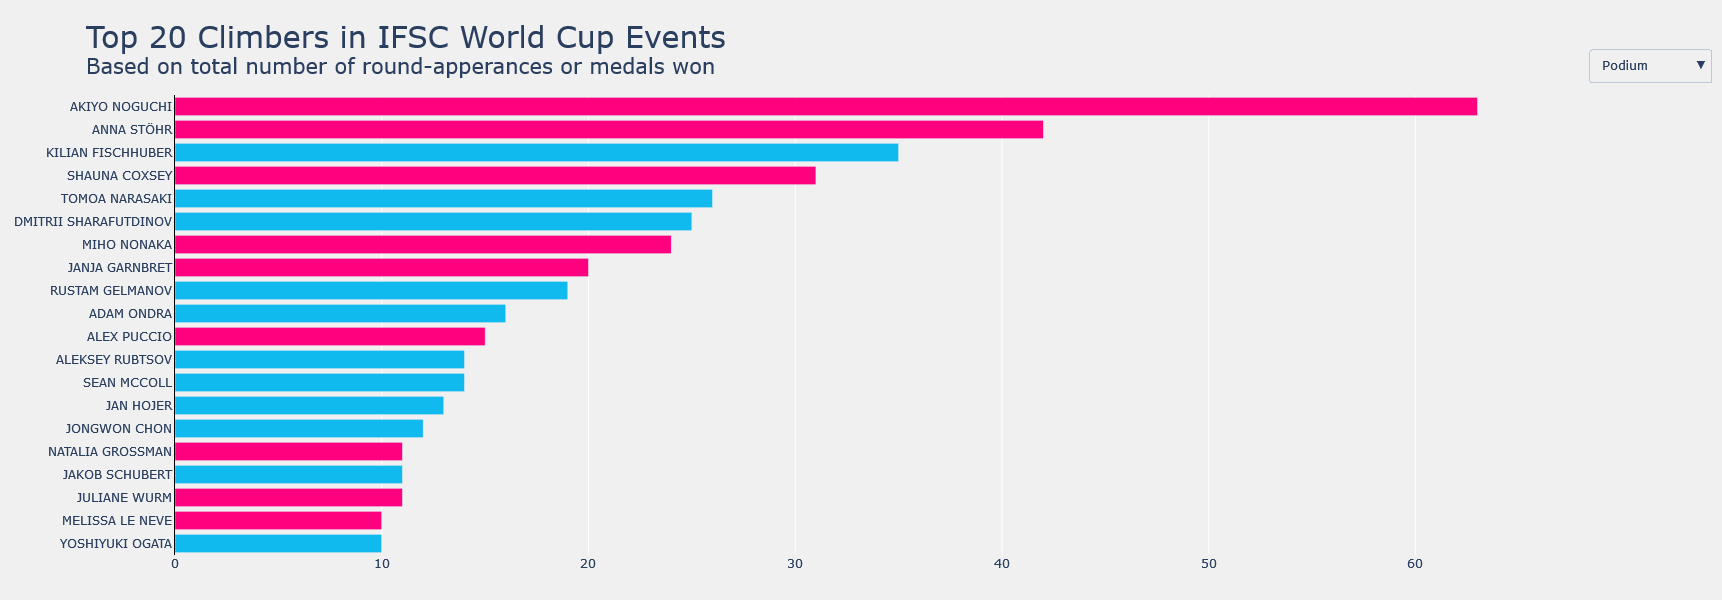

In [9]:
title = "Top 20 Climbers in IFSC World Cup Events"
sub = f"Based on total number of round-apperances or medals won"
plot.gen_bar_top20(all_boulder_podiums, title, sub)

In [10]:
def plot_bar(df, col, col2, title, sub, xoffset, yoffset, sig):
    """
    Displays a static bar graph showing the total counts of podium appearances
    of the top performing climbers between 2007-2022
    
    df: dataframe containing relevant data
    col: data to be displayed along x-axis
    col2: data to be displayed along y-axis
    title, sub, xoffset, yoffset, sig: variables for styling the various parts of the vis
    """
    #figure details
    fig = plt.figure(figsize=(10,8), facecolor='#f0f0f0')
            
    #plot
    ax = sns.barplot(data=df, x=col, y=col2, color='#10baee')
        
    #styling
    #blue = #10baee
    #pink = #ff007e
    
    ax.set_facecolor('#f0f0f0')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axvline(x=0, color="black", linewidth=6, alpha=.7)
    ax.set_xlabel('Total Podium Placements', fontsize=18)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    #title & subtitle
    ax.text(xoffset,0.94, s=title, fontsize=28, weight="bold", alpha=.75, transform=fig.transFigure)
    ax.text(xoffset,0.9, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=xoffset, y=yoffset,
            s=" ©NoahGampe" + ' '*sig + "Source: IFSC ",
            fontsize=14, color="#f0f0f0", backgroundcolor="grey", transform=fig.transFigure)
    
    plt.show()
    
# title = "Podium Counts of Most Dominant Climbers"
# sub = "Total number of times a climber reached the podium since 2007"
# plot_bar(boulder_men_stats[boulder_men_stats['Podium'] > 0].sort_values('Podium',ascending=False), 'Podium', 'Name', title, sub, -0.2, 0.025, 140)

## Podium Counts For Countries

Which countries produce the most successful climbers? Who should aspiring climbers be watching in order to improve their own training regimens? The following table can shed some light on the countries that participate in the IFSC. Historically, Russia, France, and relative newcomer Japan produce very successful climbers. Looking at the upcoming visualization can help show just *how good* those countries are at climbing.

In [11]:
def get_bouldering_country_stats(df):
    """
    Returns a dataframe showing results of all scraped IFSC events
    grouped by country.
    
    df: dataframe containing results for all bouldering events
    """
    clean_df = pd.DataFrame()
    clean_df['Country'] = df['Country'].unique()

    # Counts number of appearances per round per country
    qual_all = df.groupby(['Country'])['Qualification'].count()
    semi_app = df.groupby(['Country'])['Semi-Final'].count()
    final_app = df.groupby(['Country'])['Final'].count()

    # Merges the above with our previous dataframe
    clean_df = pd.merge(pd.merge(qual_all, semi_app , left_on='Country', right_index=True),
                  final_app, left_on='Country', right_index=True)

    # Calculates percentages of appearances vs total events
    clean_df = clean_df.sort_values('Final', ascending=False).reset_index()
    clean_df['Q_Pct'] = round((clean_df['Qualification'] / clean_df['Qualification'].sum()) * 100, 2)
    clean_df['S_Pct'] = round((clean_df['Semi-Final'] / clean_df['Semi-Final'].sum()) * 100, 2)
    clean_df['F_Pct'] = round((clean_df['Final'] / clean_df['Final'].sum()) * 100, 2)
    return clean_df

boulder_country_stats = get_bouldering_country_stats(all_results)
country_stats = calculate_podiums(all_results, boulder_country_stats, True)
show_table(country_stats, 8)

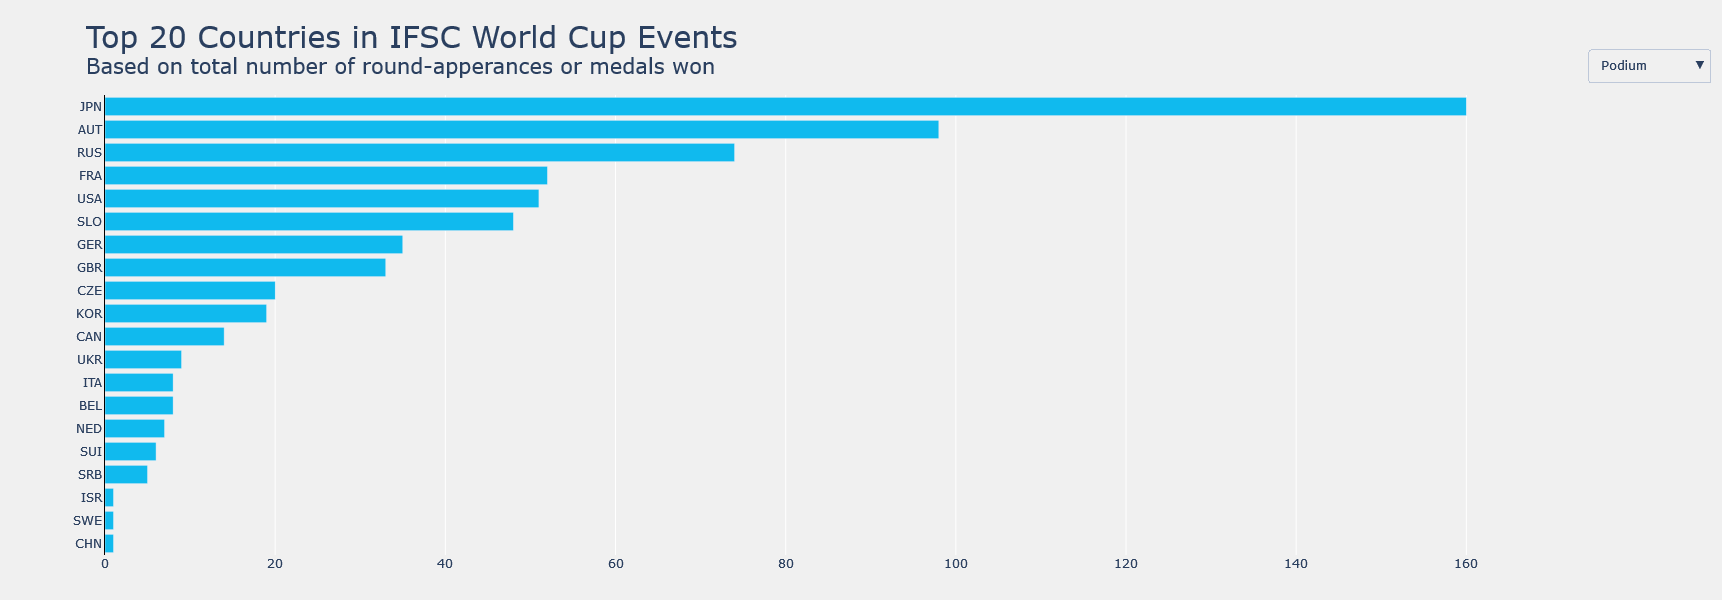

In [12]:
title = "Top 20 Countries in IFSC World Cup Events"
sub = f"Based on total number of round-apperances or medals won"
plot.gen_bar_top20(country_stats, title, sub, True)

Right away we can see that Japan, Austria, and Russia have the most gold medals - with only a single medal difference between Japan and Austria. In terms of silver medals, Japan and Austria lead the pack again, though this time the former has twice as many as the latter. A similar thing can be said with bronze medals. Japan simply produces the most medal-winning climbers. Interesting to note though, that Japan also has the second-most number of climbers competing, which would help explain how they win so much - they are simply sending more climbers to compete than most countries. Similarly, France sends the most climbers to compete, yet they come in 4th, 3rd, and 6th in terms of bronze, silver, and gold medals respectively. So it's clearly not just about sheer number of competitors.

## Number of Finalists By Country Over Time

Which countries had the strongest performance over time? We've looked at pure counts of appearances and medals, but not really the performance over time. The following table shows the number of times a climber from a given country reached the final round of a world cup event per year. According to [section 8.6 of the IFSC Rules](https://cdn.ifsc-climbing.org/images/Website/2023_IFSC_Rules_112.pdf), the quota for the Final round shall be six (6) climbers. To properly view all climbers who made it to the final round, we shall be looking at all climbers who have a rank less than or equal to 6. It's a bit difficult to discern any kind of meaningful pattern or trend from this table, but the upcoming chart will help display it visually.

In [13]:
def get_country_yearly_stats(df):
    """
    Returns df containing number of times a country has been represented in the finals.
    
    df: dataframe containing results for all bouldering events
    """
    stats_df = df[(df['Rank'] <= 6) & (df['Rank'] > 0)] # Removes any -1 or 'DNS' competitors    
    stats_df = stats_df.groupby(['Year'])['Country'].value_counts().unstack().fillna(0).astype('int')
    stats_df.index = stats_df.index.astype('int')
    return stats_df
    
country_perf = get_country_yearly_stats(all_results)
show_table(country_perf.T, 0, "asc")

In [14]:
total_finalists = country_perf.sum().sort_values(ascending=False)

# TO-DO FIGURE OUT HOW TO DISPLAY THIS ONE
total_finalists = total_finalists.reset_index(name="# of Finalists")
itables.show(total_finalists, style="table-layout:auto;width:auto;margin:auto;", scrollY="300px", scrollCollapse=True, paging=False)

Based on our earlier tables and charts, it's no surprise that Japan is at the top of the list in terms of how many of its climbers have reached the finals. Russia comes in second, but interestingly, France and Austria come in third and fourth respectively - however there's a fairly decent gap between them and Russia.

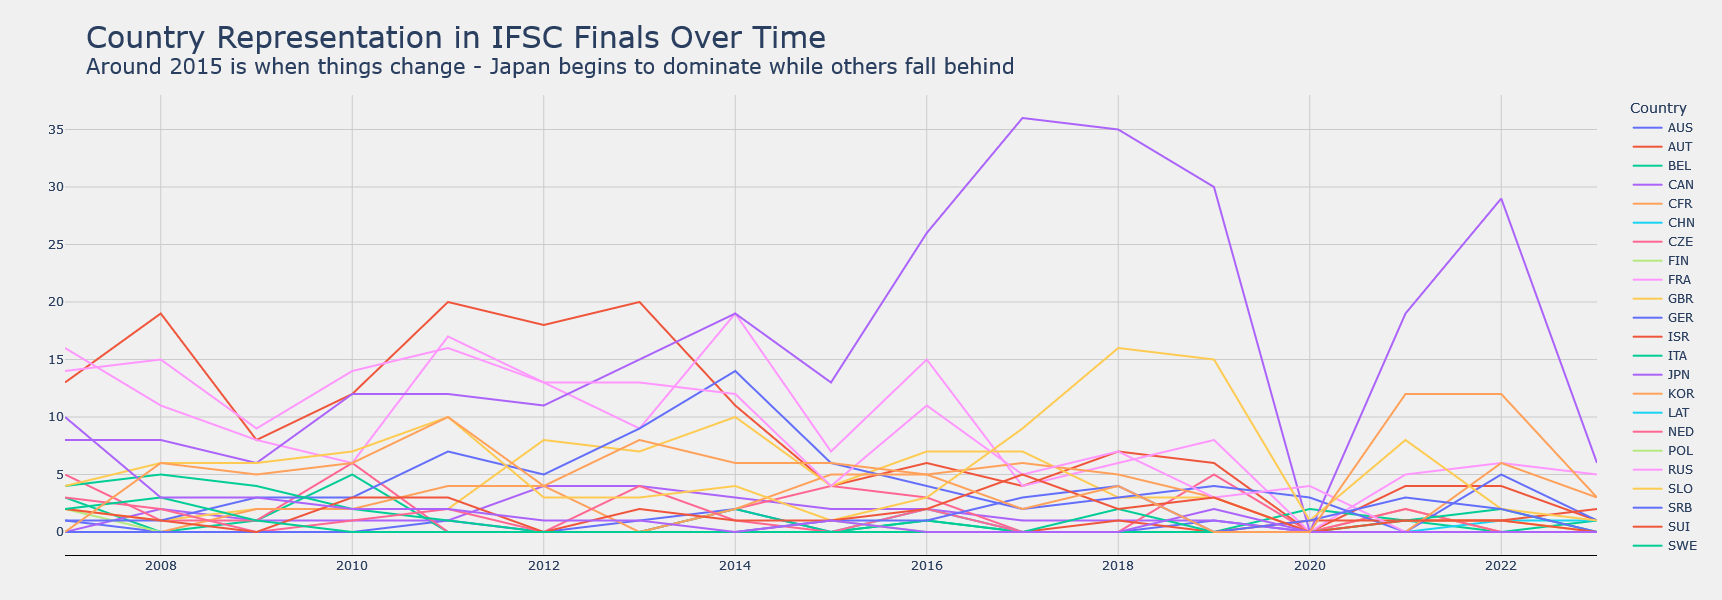

In [15]:
title = "Country Representation in IFSC Finals Over Time"
sub = "Around 2015 is when things change - Japan begins to dominate while others fall behind"
plot.gen_line(country_perf, title, sub)

If we examine the above results, it's very clear that Japan and Russia dominate bouldering competitions (in terms of the number of times one of their climbers reached the finals). Fascinatingly, Japan has reached the finals round at least once per year for every single year except 2020 - which was right in the middle of the COVID-19 pandemic, when the [IFSC cancelled two competition events](https://www.ifsc-climbing.org/index.php/news/388-ifsc-world-cups-in-salt-lake-city-and-seoul-cancelled) due to health and safety concerns. This resulted in 2020 only have a *single* bouldering event for the entire season. That one event was the European Continental Championships, so non-Europeans weren't allowed to compete anyways!

## Top Climbers By Year

Below is a bar chart that allows you to filter by year to see the top 5 performing climbers for that bouldering competition season. For the current season, [Mejdi Shalck](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=11675) is off to a hot start, with *two* gold medals in two events (Hachioji & Seoul). He's a new up & comer who will most likely have an insanely bright future and a very exciting climbing career.

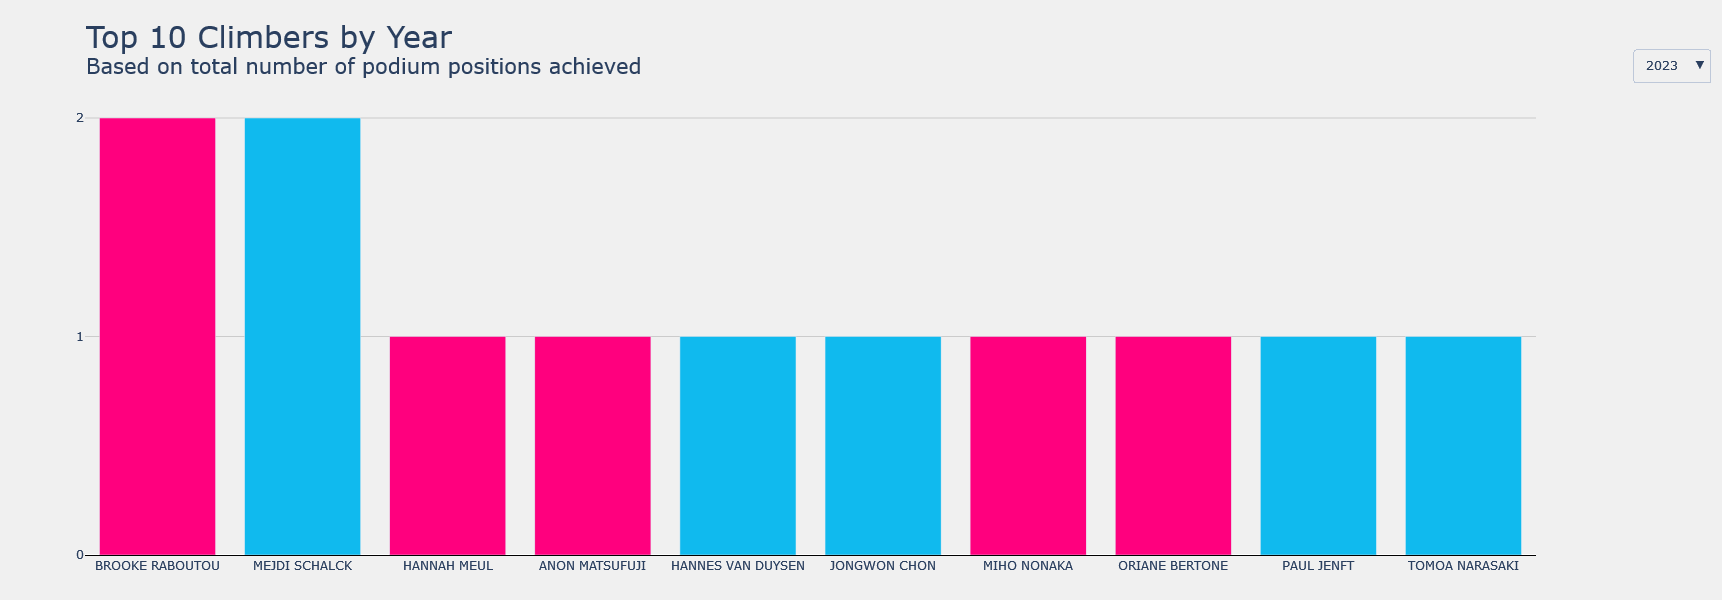

In [16]:
def get_top_by_year(df):
    """
    Returns a dataframe showing the top 10 climbers grouped by competition
    year, based on the number of times they reached the podium.
    
    df: dataframe containing results for all bouldering events
    """
    df = df[(df['Rank'] <= 3) & (df['Rank'] > 0)] # Only get climbers on podium
    df = df.groupby(['Year'])[['Name', 'Gender']].value_counts().to_frame(name='Podiums').reset_index() # Each climber's podium count by year    
    df = df.groupby(['Year'], sort=False).head(10).reset_index(drop=True).astype({'Year': 'int'}) # Top 5 climbers per year by podium count
    return df
    
top_by_year = get_top_by_year(all_results)
title = "Top 10 Climbers by Year<br><sup>Based on total number of podium positions achieved"
plot.gen_bar_top10(top_by_year, 'Year', title)

## Top Climbers By Country

If we sort by country, we can see the podium counts for individual climbers a bit better. Of particular interest is Austria (AUT), Russia (RUS), and Japan (JPN). With Austria in particular we can see that [Anna Stöhr](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=1211) and [Kilian Fischhuber](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=1204) simply *dominated* the scene with a whopping 42 and 35 medals won respectively. Similarly, [Dmitrii Sharafutdinov](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=53) of Russia and [Tomoa Narasaki](https://www.ifsc-climbing.org/index.php?option=com_ifsc&task=athlete.display&id=2276) of Japan have 26 and 25 medals respectively. But even more impressive than all of that is Akiyo Noguchi's *63* medals! No one has come even close to that number.

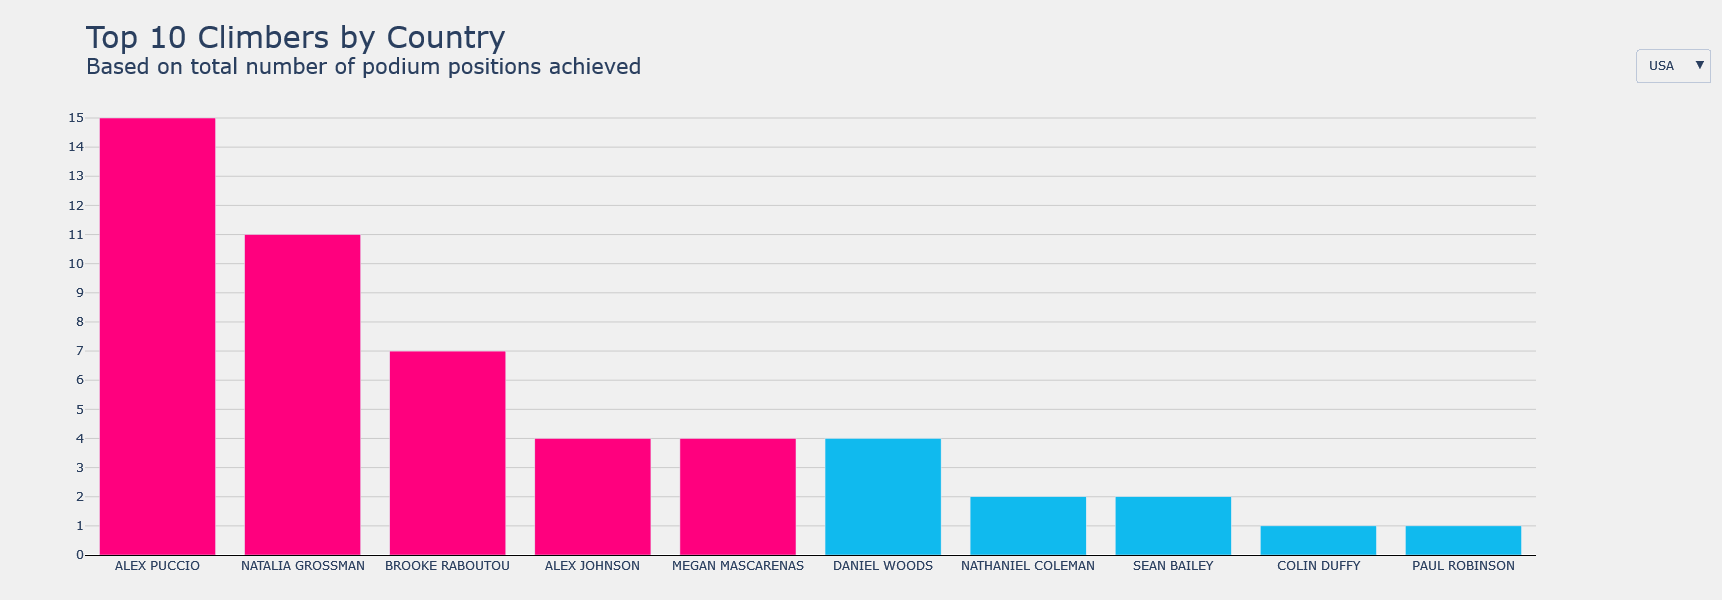

In [17]:
def get_top_by_country(df):
    """
    Returns a dataframe showing the top 10 climbers (if applicable)
    grouped by country.
    
    df: dataframe containing results for all bouldering events
    """
    df = df[(df['Rank'] <= 3) & (df['Rank'] > 0)] # Only get climbers on podium
    df = df.groupby(['Country'])[['Name', 'Gender']].value_counts().to_frame(name='Podiums').reset_index() # Each climber's podium count by year    
    df = df.groupby(['Country'], sort=False).head(10).reset_index(drop=True) # Top 5 climbers per year by country
    return df
    
top_by_country = get_top_by_country(all_results)
title = "Top 10 Climbers by Country<br><sup>Based on total number of podium positions achieved"
plot.gen_bar_top10(top_by_country, 'Country', title)

## Map of Country's Participation in IFSC World Cup Events

In [18]:
def get_round_stats(df, rnd=0):
    """
    Returns an aggregated dataframe with the climbers for a given round.
    
    rnd: the round you want data for (0: qualification, 1: semi-final, 2: final, 3:podium)
    """
    if rnd == 1:
        df = df[(df['Rank'] <= 20) & (df['Rank'] > 0)] # Semi-Final
    elif rnd == 2:
        df = df[(df['Rank'] <= 6) & (df['Rank'] > 0)]  # Final
    elif rnd == 3:
        df = df[(df['Rank'] <= 3) & (df['Rank'] > 0)]  # Podium
    
    df = df.groupby(['Year'])['Country'].value_counts().unstack().fillna(0).astype('int')
    return df
    
qual   = get_round_stats(all_results)
semif  = get_round_stats(all_results, 1)
final  = get_round_stats(all_results, 2)
podium = get_round_stats(all_results, 3)
    
title = "Worldwide Distribution of Athletes in the Qualifiers"
sub1 = "Climbing has grown in popularity over time - seeing more athletes from more countries"
plot.gen_choro(qual, title, sub1, YEARS)

In [19]:
title = "Distribution of Athletes on the Podium "
sub4 = "Japan is incredibly consistent - especially after 2015"
plot.gen_choro(podium, title, sub4, YEARS)

## Individual Finals Appearances Over Time

We've seen the overall quantity of who's won the most, but the following visualization helps show the performance of a climber over their careers. To make the visualization a bit less cluttered, only climbers who appeared in *at least* 3 finals are included. The values have been sorted by the weighted average of final appearence per year, so it more accurately shows that climber's highpoint in their career. You can see how each climber performed year-to-year, and it's easier to see when a climber bursts onto the scene, and when they slowly get phased out by younger climbers.

In [20]:
plot.plot_heatmap(all_results)

### Observations

Below is a short list of climbers that have either performed well for an extended period of time, or are proving that they are force to be reckoned with. In no particular order:

| Men | Women |
| --- | --- |
| Kilian Fischhuber | Anna Stöhr |
| Dmitrii Sharafutdinov | Alex Puccio |
| Sean McColl | Akiyo Noguchi |
| Adam Ondra | Shauna Coxsey |
| Jakob Schubert | Miho Nonaka |
| Jan Hojer | Fanny Gibert |
| Jongwon Chon | Stasa Gejo |
| Tomoa Narasaki | Brooke Rabatou |
| Kokoro Fujii | Natalia Grossman |
| Yoshiyuki Ogata | Oriane Bertone |

All of the above climbers have been in finals over at least 10 years, or they seem to be rising stars leaving their mark on the competitive climbing scene. 

## Event Statistics (In-Progress)

Below is table representing some statistics from each unique event. It is fairly self-explanatory, with columns depicting the `Event` name, `Year`, `Location`, number of `Climbers`, and then the last six columns represent the total number of tops for each round (`Q_Top`, `S_Top`, `F_Top`), as well as the percentage of tops made based on the number of climbers (`Q_Top%`, `S_Top%`, `F_Top%`). The final three columns effectively represent how difficult each competition was, as it is a measurement of how many tops were made versus the maximum number of tops possible for the given round.

*Note*: In 2007, the Qualification round was different than every other year, as climbers had to climb *six* boulders instead of five. The below table takes this into account.

In [21]:
def clean_boulder(df):
    """
    Returns a dataframe where each score has been broken out
    into multiple columns for easier manipulation.
    
    df: dataframe containing results for all bouldering events
    """
    # Gets tops and zones for qualifications
    df[['Q_Top', 'Q_Zone']] = df['Qualification'].str.split('T', expand=True)
    df['Q_Zone'] = df['Q_Zone'].str.split('Z', expand=True)[0]
    # df[['Qualification', 'QT_Att', 'QZ_Att']] = df['Qualification'].str.split(expand=True)

    # Gets tops and zones for semi-finals
    df[['S_Top', 'S_Zone']] = df['Semi-Final'].str.split('T', expand=True)
    df['S_Zone'] = df['S_Zone'].str.split('Z', expand=True)[0]
    # df[['Semi-Final', 'ST_Att', 'SZ_Att']] = df['Semi-Final'].str.split(expand=True)

    # Gets tops and zones for finals
    df[['F_Top', 'F_Zone']] = df['Final'].str.split('T', expand=True)
    df['F_Zone'] = df['F_Zone'].str.split('Z', expand=True)[0]
    # df[['Final', 'FT_Att', 'FZ_Att']] = df['Final'].str.split(expand=True)

    new_cols = ['Q_Top', 'Q_Zone',
                'S_Top', 'S_Zone',
                'F_Top', 'F_Zone']
    
    dns_cols = ['Qualification', 'Semi-Final', 'Final']
    
    # Convert all new columns to int
    for col in new_cols:
        df[col] = df[col].replace('DNS', np.nan)
        df[col] = df[col].astype('Int64')

    return df

clean_results = clean_boulder(all_results)

In [22]:
def get_event_stats(df):
    """
    Calculates the percentages of tops for each round, as well as
    total counts for tops, zones, and attempts.
    
    df: cleaned data frame that has expanded climbers score
    """
    cols = ['Q_Top', 'S_Top', 'F_Top',]
    
    df_sum = df.groupby(['Event', 'Year', 'Location'])[cols].sum()
    df_sum['Climbers'] = df.groupby(['Event', 'Year'])['Name'].count()    
    df_sum.reset_index(inplace=True)
    df_sum['Event'] = df_sum['Event'].str.split(r'Cup|Championships|Championship').str[-1]
    
    df_sum['Q_Top%'] = round((df_sum['Q_Top'] / (df_sum['Climbers'] * 5)) * 100, 2)
    df_sum['S_Top%'] = round((df_sum['S_Top'] / 160) * 100, 2) # Semi-Finals = 40 climbers x 4 boulders
    df_sum['F_Top%'] = round((df_sum['F_Top'] / 48) * 100, 2) # Finals = 12 climbers x 4 boulders

    # Special case where 2007 qualification had 6 boulders instead of 5
    idx = df_sum.index[df_sum['Year'] == '2007']
    df_sum.loc[idx, ['Q_Top%']] = round((df_sum['Q_Top'] / (df_sum['Climbers'] * 6)) * 100, 2)
    
    col_order = ['Event', 'Year', 'Location', 'Climbers', 'Q_Top', 
                 'S_Top', 'F_Top', 'Q_Top%', 'S_Top%', 'F_Top%' ]
    df_sum = df_sum[col_order]
    
    return df_sum.sort_values('Year')
        
event_stats = get_event_stats(clean_results)
show_table(event_stats, 2, 'asc')

In [23]:
def calc_perc(col):
    stat_cols = ['Event', 'Climbers', 'Q_Top', 'S_Top', 'F_Top']
    df = event_stats.groupby([col])[stat_cols].sum()
    df['Event'] = event_stats.groupby([col])['Event'].count()
    
    #  Top %     = ( Total Tops / Max. Possible Tops ) * 100
    df['Q_Top%'] = (df['Q_Top'] / (df['Climbers'] * 5)) * 100.0
    df['S_Top%'] = (df['S_Top'] / (df['Event'] * 160)) * 100.0
    df['F_Top%'] = (df['F_Top'] / (df['Event'] * 48)) * 100.0
    
    # 2007 had 6 boulders for qualifier rounds, which alters the statistic
    if df.index[0] == 2007:
        df.loc[2007, 'Q_Top%'] = (df.loc[2007, 'Q_Top'] / (df.loc[2007, 'Climbers'] * 6)) * 100.0
        
    return df

year_stats = calc_perc('Year')
locale_stats = calc_perc('Location')

In [24]:
# def agg_stat(df, col):
#     # num_events['Event'] = df.groupby(['Year'])['Event'].count()
#     tab = pd.DataFrame(np.nan, index=ROUNDS, columns=np.unique(df[col]))
#     groups = df.groupby([col])

#     for agg, group in groups:
#         sub = group.loc[:, ['Q_Top', 'S_Top', 'F_Top']]

#         if agg[0] == 2007:
#             print('testing')
#         q_boulders = 6 if agg[0] == 2007 else 5
#         q_tops = sub.sum()[0]
#         s_tops = sub.sum()[1]
#         f_tops = sub.sum()[2]
#         q_total = sub.notna().sum()[0] * q_boulders # Quali has 5-6 boulders
#         s_total = sub.notna().sum()[1] * 4 # Semi & Finals have 4 boulders each
#         f_total = sub.notna().sum()[2] * 4
        
#         tab.loc[ROUNDS[0], agg[0]] = (q_tops/q_total)*100.0
#         tab.loc[ROUNDS[1], agg[0]] = (s_tops/s_total)*100.0
#         tab.loc[ROUNDS[2], agg[0]] = (f_tops/f_total)*100.0

#     return tab

# year_stat = agg_stat(clean_results, 'Year')
# loc_stat = agg_stat(clean_results, 'Location')

In [25]:
# year_stats
# locale_stats

In [26]:
title = "Competition Location Statistics"
sub = "Austria, China, Germany, and the USA are hosts of more events"
plot.plot_event(locale_stats, title, sub)

In [27]:
title = "Competition Yearly Statistics"
sub = "The number of climbers increased gradually until the pandemic in 2020"
plot.plot_event(year_stats, title, sub)

In [28]:
title = "Competition Event Statistics"
sub = "The number of climbers per event over time is steadily increasing"
event_stats.set_index('Event', inplace=True)
plot.plot_event(event_stats, title, sub)

## To-Do
* combine previous three graphs for more interesting visualization
* regex for event names for consistency
* color schemes?
* rework plot functions for more modularity

# Summary
(to-do)